In [8]:
#Import and classes
import numpy as np
from matplotlib import pyplot as plt
from IPython import display

def pwm_control(w_desired,w_measured,Kp,Ki,e_sum):
    
    duty_cycle = min(max(0,Kp*(w_desired-w_measured) + Ki*e_sum),1)
    e_sum = e_sum + w_desired-w_measured
    
    return duty_cycle, e_sum

def motor_simulator(w,duty_cycle):

    I = 5
    dt = 0.1
    d = 1
    
    torque = I*duty_cycle

    if (w > 0):
        w = min(w + dt*(torque - d*w),3)
    elif (w < 0):
        w = max(w + dt*(torque - d*w),-3)
    else:
        w = w + dt*(torque)

    return w

class DiffDriveRobot:
    
    def __init__(self,inertia=5, dt=0.1, drag=0.2, wheel_radius=0.05, wheel_sep=0.15):
        
        self.x = 0.0 # y-position
        self.y = -0.9 # y-position 
        self.th = 90 # orientation
        
        self.wl = 0.0 #rotational velocity left wheel
        self.wr = 0.0 #rotational velocity right wheel
        
        self.I = inertia
        self.d = drag
        self.dt = dt
        
        self.r = wheel_radius
        self.l = wheel_sep
    
    # Should be replaced by motor encoder measurement which measures how fast wheel is turning
    # Here, we simulate the real system and measurement
    def motor_simulator(self,w,duty_cycle):
        
        torque = self.I*duty_cycle
        
        if (w > 0):
            w = min(w + self.dt*(torque - self.d*w),3)
        elif (w < 0):
            w = max(w + self.dt*(torque - self.d*w),-3)
        else:
            w = w + self.dt*(torque)
        
        return w
    
    # Veclocity motion model
    def base_velocity(self,wl,wr):
        
        v = (wl*self.r + wr*self.r)/2.0
        
        w = (wl*self.r - wr*self.r)/self.l
        
        return v, w
    
    # Kinematic motion model
    def pose_update(self,duty_cycle_l,duty_cycle_r):
        
        self.wl = self.motor_simulator(self.wl,duty_cycle_l)
        self.wr = self.motor_simulator(self.wr,duty_cycle_r)
        
        v, w = self.base_velocity(self.wl,self.wr)
        
        self.x = self.x + self.dt*v*np.cos(self.th)
        self.y = self.y + self.dt*v*np.sin(self.th)
        self.th = self.th + w*self.dt
        
        return self.x, self.y, self.th
        
class RobotController:
    
    def __init__(self,Kp=0.1,Ki=0.01,wheel_radius=0.02, wheel_sep=0.1):
        
        self.Kp = Kp
        self.Ki = Ki
        self.r = wheel_radius
        self.l = wheel_sep
        self.e_sum_l = 0
        self.e_sum_r = 0
        
    def p_control(self,w_desired,w_measured,e_sum):
        
        duty_cycle = min(max(-1,self.Kp*(w_desired-w_measured) + self.Ki*e_sum),1)
        
        e_sum = e_sum + (w_desired-w_measured)
        
        return duty_cycle, e_sum
        
        
    def drive(self,v_desired,w_desired,wl,wr):
        
        wl_desired = (v_desired + self.l*w_desired/2)/self.r
        wr_desired = (v_desired - self.l*w_desired/2)/self.r
        
        duty_cycle_l,self.e_sum_l = self.p_control(wl_desired,wl,self.e_sum_l)
        duty_cycle_r,self.e_sum_r = self.p_control(wr_desired,wr,self.e_sum_r)
        
        return duty_cycle_l, duty_cycle_r
        


class TentaclePlanner:
    
    def __init__(self,obstacles,dt=0.1,steps=7,alpha=1,beta=0.1):
        
        self.dt = dt
        self.steps = steps
        # Tentacles are possible trajectories to follow
        self.tentacles = [(0.0,0.5),(0.0,-0.5),(0.1,1.0),(0.1,-1.0),(0.1,0.5),(0.1,-0.5),(0.1,0.0),(0.0,0.0)]
        
        self.alpha = alpha
        self.beta = beta

        self.obstacles = obstacles
    
    # Play a trajectory and evaluate where you'd end up
    def roll_out(self,v,w,goal_x,goal_y,goal_th,x,y,th):
        
        for j in range(self.steps):
        
            x = x + self.dt*v*np.cos(th)
            y = y + self.dt*v*np.sin(th)
            th = (th + w*self.dt)
            if (self.check_collision(x,y)):
                return np.inf
        
        e_th = goal_th-th
        e_th = np.arctan2(np.sin(e_th),np.cos(e_th))
        
        return self.alpha*((goal_x-x)**2 + (goal_y-y)**2) + self.beta*(e_th**2)

    def check_collision(self,x,y):
        
        min_obstacle_dist = np.min(np.sqrt((x-self.obstacles[:,0])**2+(y-self.obstacles[:,1])**2))

        
        if (min_obstacle_dist < 0.15 and x in (-1.9,1.9) and y in (-1.9,1.9) ):
            return True
        return False
    
    # Choose trajectory that will get you closest to the goal
    def plan(self,goal_x,goal_y,goal_th,x,y,th):
        
        costs =[]
        for v,w in self.tentacles:
            costs.append(self.roll_out(v,w,goal_x,goal_y,goal_th,x,y,th))
        
        best_idx = np.argmin(costs)
        print(th)
        
        return self.tentacles[best_idx]
        

[[ 0.75611313 -0.05544266]]
90
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
90.0
89.97750000000568
89.96225000000794
89.95271250000815
89.94736625000724
89.94488868750585
89.9442268812544
89.94460107281557
89.94547238928325
89.94649578176838
89.94747109010201
89.94829924071442
89.94894661469664
89.94941815920022
89.94973845016457
89.94993929665029
89.950052328974
89.95010512982219
89.95011970903973
89.95011239949896
89.95009451205269
89.9500733071368
89.95005301116386
89.95003572938258
89.95002219027458
89.95001230845855
89.95000558194782
89.9500013527862
89.94999896337808
89.94999783851655
89.94999751814967
89.94999766018834
89.9499980272351
89.94999846653025
89.94999888

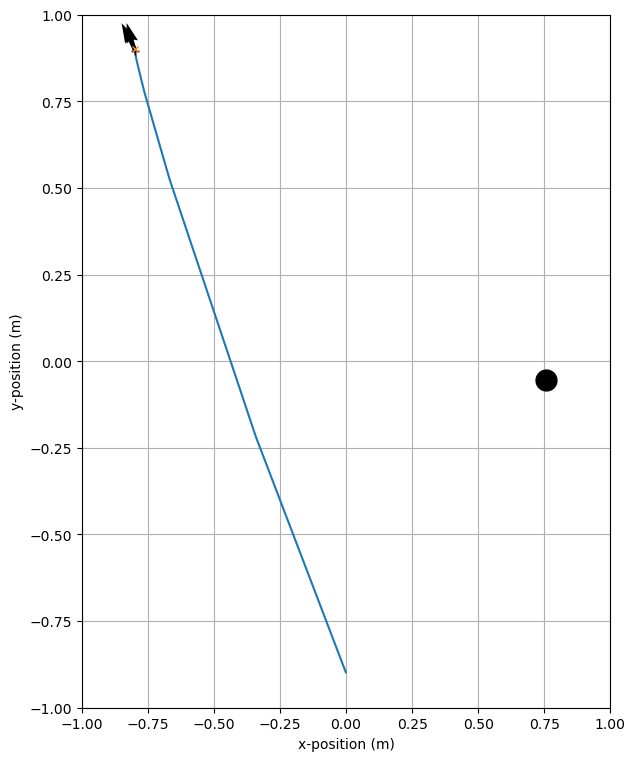

In [14]:
robot = DiffDriveRobot(inertia=5, dt=0.1, drag=1, wheel_radius=0.05, wheel_sep=0.15)
controller = RobotController(Kp=1,Ki=0.25,wheel_radius=0.05,wheel_sep=0.15)
obstacles = 2*np.random.rand(1,2)-1 ## turn into rectangle obstacles
print(obstacles)
planner = TentaclePlanner(obstacles, dt=0.1,steps=5,alpha=1,beta=1e-5)

plt.figure(figsize=(15,9))

poses = []
velocities = []
duty_cycle_commands = []
goals_x = np.array([-0.8, 0, 0.8])
idx = np.random.randint(0,2)
goal_x = goals_x[idx] #top left of arena
goal_y = 0.9
goal_th = 90

for i in range(200):

    # Plan using tentacles
    v,w = planner.plan(goal_x,goal_y,goal_th,robot.x,robot.y,robot.th)
    
    duty_cycle_l,duty_cycle_r = controller.drive(v,w,robot.wl,robot.wr)
    
    # Simulate robot motion - send duty cycle command to robot
    x,y,th = robot.pose_update(duty_cycle_l,duty_cycle_r)
    
    # Log data
    poses.append([x,y,th])
    duty_cycle_commands.append([duty_cycle_l,duty_cycle_r])
    velocities.append([robot.wl,robot.wr])
    
# Plot robot data
plt.clf()
plt.subplot(1,2,1)   
plt.plot(np.array(poses)[:,0],np.array(poses)[:,1])
plt.plot(x,y,'k',marker='+')
plt.quiver(x,y,0.1*np.cos(th),0.1*np.sin(th))
plt.plot(goal_x,goal_y,'x',markersize=5)
plt.quiver(goal_x,goal_y,0.1*np.cos(goal_th),0.1*np.sin(goal_th))
plt.plot(obstacles[:,0],obstacles[:,1],'ko',markersize=15)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('x-position (m)')
plt.ylabel('y-position (m)')
plt.grid()
plt.show()

    
    